Multiple design files. Type # of file and confirm with enter 

#1 ABDesign310518_FNTJSWv3.dxf
#2 Clewin HUBBARD FULL horizontal.dxf
#3 clewin4thewinsag.dxf
#4 DesignArrays.dxf
#5 fulldesign_vol3.dxf
#6 hubbardtest.dxf
#7 hubbardtest.gds
#8 it werks.dxf
#9 itwerks.dxf
#10 newfile1.gds
#11 newfile2.gds
#12 SCONmergertestfolder\gimmefacnyname.dxf
#13 testlayerstuff.gds
13
Multiple symbols. Type # of symbol defining marks 

#1 'amoreoutthanmain'
#2 'intermediatesybol'
#3 'wonderifthisisouttest'
#4 'marks'
4
Multiple layers. Type # of layer containing marks 

#1 4
#2 5
1
-182000.0 244000.0
18000.0 428000.0
282000.0 266000.0
482000.0 450000.0
-188000.0 -204000.0
12000.0 -20000.0
262000.0 -174000.0
462000.0 10000.0
1460000.0 -454000.0
1660000.0 -270000.0
1915000.0 -445000.0
2115000.0 -261000.0
1470000.0 -850000.0
1670000.0 -666000.0
1935000.0 -825000.0
2135000.0 -641000.0
2190000.0 -608000.0
2390000.0 -424000.0
2654000.0 -586000.0
2854000.0 -402000.0
2184000.0 -1056000.0
2384000.0 -872000.0
2

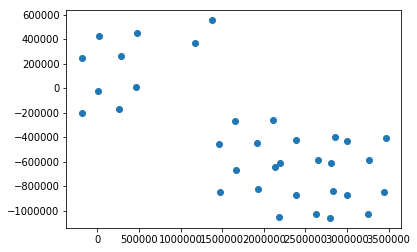

In [4]:
from collections import Counter 
import os
from gdsii.library import Library
from gdsii.elements import *
import time as time
import ezdxf
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster



paths=getListOfFiles()   #or could be done with a folder but i think its best to search in the folder the script is sitting in
                        #so ideally there would be only one file in that folder, then program can autofind it
filename=finddxforGdsii(paths)

if '.gds' in filename:

    lib,targetsymbol,layer,units=openaskfortargetlayerandunits(filename)

    mainspace = findtopstructure(lib)

    symboldictionary = createsymboldictionary(lib)   #recursive search asks for this global variable with this name
    
    marks = []  #recursive search asks for this global variable with this name
    marksinsymbol=[]
    if 1:
        pointsinsymbol=allpointsinsymbol(targetsymbol,layer)
        marksinsymbol=findalllignmentmarks(pointsinsymbol,max_d=140000) 
    
    recursivesearch(targetsymbol,mainspace)

    
    
if '.dxf' in filename:
    
    max_distance = 213 #max size of alignment mark in µm



    doc = ezdxf.readfile(filename)

    layer = finddxflayer(doc,keyword='')

    points=findallpointsdxf(doc,layer)
    marks=findalllignmentmarks(points,max_d=250)
    
    
writemarksintotxt(filename,marks,1) 
    
    
import matplotlib.pyplot as plt
import numpy as np

b=np.array(marks)
plt.figure()
plt.plot(b[:,0],b[:,1],lw=0,marker='o')
plt.show()    
#usedmarks=findoutermostmarks(marks)
    
#scon = findscon(paths)
    
#writemarksintoscon(scon,usedmarks,units)

In [1]:
# All functions use in main programms

from collections import Counter 
import os
from gdsii.library import Library
from gdsii.elements import *
import time as time
import ezdxf
import numpy as np
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.cluster.hierarchy import fcluster




#GDSII


def openaskfortargetlayerandunits(filename):
    
    with open(filename, 'rb') as stream:
        lib = Library.load(stream)
    
    
    userindex=1
   
    if len(lib)==1:
        print('Only the mainsymbol found, please create a subsymbol for alignmentmarks')
        return
    elif len(lib)>1:
        print('Multiple symbols. Type # of symbol defining marks \n')
        for index,symbol in enumerate(lib):
                print('#'+str(index+1)+' '+str(symbol.name)[1:])
    
    userindex=int(input())
    targetsymbolname=lib[userindex-1].name
    
    
    alllayer=[]
    for symbol in lib:
        for objects in symbol:
            if isinstance(objects,Boundary) or isinstance(objects,Box):
                if objects.layer not in alllayer:
                    alllayer.append(objects.layer)
                    
    if len(alllayer)==1:
        print('Only one layer found')
        return
    elif len(alllayer)>1:
        print('Multiple layers. Type # of layer containing marks \n')
        for index,symbol in enumerate(alllayer):
                print('#'+str(index+1)+' '+str(symbol))
    
    userindex=int(input())
    targetlayer=alllayer[userindex-1]

    
    return(lib,targetsymbolname,[targetlayer],int(round(lib.physical_unit*1e9)))




def recursivesearch(symboltofind,insymbol,x=0,y=0):
    
    global marks
    global symboldictionary
    global marksinsymbol
    
    for objects in insymbol:
        if isinstance(objects,SRef):
            if objects.struct_name == symboltofind:
                if len(marksinsymbol)==0:
                    marks.append((objects.xy[0][0]+x,objects.xy[0][1]+y))
                else:
                    for eachmark in marksinsymbol:
                        marks.append((objects.xy[0][0]+x+eachmark[0],objects.xy[0][1]+y+eachmark[1]))
                
                
                
                
            elif objects.struct_name != symboltofind:
                x1,y1 = objects.xy[0]
                
                recursivesearch(symboltofind,symboldictionary[objects.struct_name],x+x1,y+y1) 

           
                
def allpointsinsymbol(symbolname,layers):

    points=[]
    
    for symbol in lib:
        if symbol.name == symbolname:
            for objects in symbol:
                if isinstance(objects,Boundary):
                    if objects.layer in layers:
                        for xy in objects.xy[:-1]:
                            points.append(xy)
    return points



def createsymboldictionary(lib):
    dictlib={}
    for symbols in lib:
        dictlib[symbols.name] = symbols
    return dictlib 



def isreferencedin(structure,instructure):
    for someobject in instructure:
        if isinstance(someobject,SRef) or isinstance(someobject,ARef):
            if someobject.struct_name == structure.name:
                return True
    return False



def findtopstructure(lib):
    for symbols in lib:
        top = True
        for symbols2 in lib:
            if isreferencedin(symbols,symbols2):
                top=False
            
        if top==True:
            return symbols








##SCON WRITING

def writemarksintoscon(scon,marks,units):
    f=open(scon,'r')
    scontent=f.read()
    if any(regtype in scontent for regtype in ['RL2 ','RL3 ','RL4 ']):
        print('File already has marks, not overwriting')
        return
    sconparts=scontent.split('PC, ')
    if len(marks)==4:
        outputscon=sconparts[0]+'RL4 %.3f, %.3f, %.3f, %.3f, %.3f, %.3f, %.3f, %.3f \n' %(marks[0][0]*units/1000,marks[0][1]*units/1000,marks[1][0]*units/1000,marks[1][1]*units/1000,marks[2][0]*units/1000,marks[2][1]*units/1000,marks[3][0]*units/1000,marks[3][1]*units/1000)
    elif len(marks)==3:
        outputscon=sconparts[0]+'RL3 %.3f, %.3f, %.3f, %.3f, %.3f, %.3f \n' %(marks[0][0]*units/1000,marks[0][1]*units/1000,marks[1][0]*units/1000,marks[1][1]*units/1000,marks[2][0]*units/1000,marks[2][1]*units/1000)    
    elif len(marks)==2:
        outputscon=sconparts[0]+'RL2 %.3f, %.3f, %.3f, %.3f \n' %(marks[0][0]*units/1000,marks[0][1]*units/1000,marks[1][0]*units/1000,marks[1][1]*units/1000) 
    
    for index,i in enumerate(sconparts):
        if index>0:
            outputscon=outputscon+'PC, '+i
        
    outputfilename=scon[:-5]+'Marks'+scon[-5:]
    
    f= open(outputfilename,"w+")
    f.write(outputscon)
    f.close
    
    
def writemarksintotxt(name,marks,units):
    outputscon=''
    for mark in marks:
        print(mark[0],mark[1])
        outputscon=outputscon+'%.3f, %.3f \n' %(mark[0],mark[1])
        
    outputfilename=name[:-5]+'Marks.txt'
    
    f= open(outputfilename,"w+")
    f.write(outputscon)
    f.close
       

        
def findscon(paths):
    allscon=[]
    userindex=1
    for file in paths:
        if '.scon' in file:
            allscon.append(file)
    if len(allscon)==0:
        print('No Scon file in folder')
        return
    elif len(allscon)>1:
        print('Multiple Scon files. Type # of file and confirm with enter \n')
        for index,sconfile in enumerate(allscon):
                print('#'+str(index+1)+' '+sconfile)
        userindex=int(input())
    return(allscon[userindex-1])



## DXF FUNCTIONS


def findallpointsdxf(doc,layers):
    

    msp = doc.modelspace()
    
    points=[]
    
    polylines = msp.query('POLYLINE')
    lwpolys = msp.query('LWPOLYLINE')

    for polyline in polylines:
        if polyline.dxf.layer in layers:
            for location in polyline.points():
                if [location[0],location[1]] not in points:
                    points.append([location[0],location[1]])
    
    for polyline in lwpolys:
        if polyline.dxf.layer in layers:
            for location in polyline.points():
                if [location[0],location[1]] not in points:
                    points.append([location[0],location[1]])
          
    return(points)



def finddxflayer(doc,keyword=''):
    alllayers=[]
    for layer in doc.layers:
        if keyword.lower() in layer.dxf.name.lower():
            alllayers.append(layer.dxf.name)
    
    userindex=1
   
    if len(alllayers)==0:
        print('No layer with keyword found in folder')
        return
    elif len(alllayers)>1:
        print('Multiple layers. Type # of layer and confirm with enter \n')
        for index,layer in enumerate(alllayers):
                print('#'+str(index+1)+' '+layer)
        userindex=int(input())
    return([alllayers[userindex-1]])




## NOT FILEDEPENDENT

#This finds all files that are in the same folder as the script and in 1st level subfolders
#could be expanded iteratively but no priority right now
def getListOfFiles():  
    listOfFile = os.listdir()     
    allFiles = []
    # Iterate over all the entries
    for entry in listOfFile:
        if os.path.isdir(entry):
            subfolder=os.listdir(entry)
            for allsubfiles in subfolder:
                allFiles.append(os.path.join(entry,allsubfiles))
        else:
            allFiles.append(entry)
                
    return allFiles


#This asks/returns files, If there is only one file it autouses it
def finddxforGdsii(paths):
    allvectorgraphic=[]
    userindex=1
    for file in paths:
        if '.dxf' in file or '.gds' in file:
            allvectorgraphic.append(file)
    if len(allvectorgraphic)==0:
        print('No design file in folder')
        return
    elif len(allvectorgraphic)>1:
        print('Multiple design files. Type # of file and confirm with enter \n')
        for index,vecfile in enumerate(allvectorgraphic):
                print('#'+str(index+1)+' '+vecfile)
        userindex=int(input())
    return(allvectorgraphic[userindex-1])


#This is the corefunction, it groups corner points into clusters no larger than max_d in any direction
#then does all parewise centers and picks the most frequent one,
#rounds number to accurcay decimals points (usefull for inaccuracies, i guess rounding depends on units µm or nm)
def findalllignmentmarks(points,max_d=250):   
    accuracy=4
    Z = linkage(points,method='complete',metric='euclidean')                           
    
    
                     
    clusters = fcluster(Z, max_d, criterion='distance')
    
    
    allclusters=[]
    for i in range(1,max(clusters)+1):
        clusterslist=[]
        for j in range(len(clusters)):
            
            if clusters[j]==i:
                clusterslist.append(points[j])
        allclusters.append(clusterslist)
    
        
        
     
    
    
    alignmentmarks = []
    for j in allclusters:
        centers=[]
        for i in j:
            for k in j:
                x=(i[0]+k[0])/2
                y=(i[1]+k[1])/2
                
                x=round(x,accuracy)
                y=round(y,accuracy)
                
                centers.append((x,y))
        
        alignmentmarks.append(most_frequent(centers))
    
    return alignmentmarks


## USED ONLY BY findalllignmentmarks
def most_frequent(List): 
    occurence_count = Counter(List) 
    return occurence_count.most_common(1)[0][0] 
    
    
    
## Finds the 4 marks farthers away from the center, the center, it uses diamonds moving outwards to detemind the distance  
def findoutermostmarks(marks):   # and sort them
    LL=[0,-100000000]
    LR=[0,-100000000]
    UR=[0,-100000000]
    UL=[0,-100000000]
    for markindex,mark in enumerate(marks):
        LLscore=-mark[0]-mark[1]
        LRscore=-mark[0]+mark[1]
        ULscore=mark[0]-mark[1]
        URscore=mark[0]+mark[1]
        if LLscore>LL[1]:
            LL[1]=LLscore
            LL[0]=markindex
        if LRscore>LR[1]:
            LR[1]=LRscore
            LR[0]=markindex
        if ULscore>UL[1]:
            UL[1]=ULscore
            UL[0]=markindex
        if URscore>UR[1]:
            UR[1]=URscore
            UR[0]=markindex
    return [marks[LL[0]],marks[LR[0]],marks[UL[0]],marks[UR[0]]]



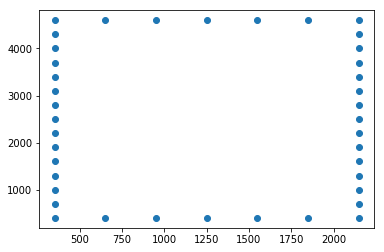